In [1]:
# refresh imports
%load_ext autoreload
%autoreload 2

import torch
import pandas as pd
import chess
from tqdm import tqdm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from utils import   get_FenBatchProvider, transform
from stockfish_explain.gen_concepts import create_custom_concepts

# set default plot size as large
plt.rcParams['figure.figsize'] = [20, 10]




In [2]:
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm
import pandas as pd
import sqlite3
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    ElasticNet,
    LogisticRegression,
    Ridge,
    RidgeClassifier,
    SGDRegressor,
    LinearRegression,
)
from sklearn.svm import SVC
from lightgbm import LGBMClassifier, LGBMRegressor

from imblearn.under_sampling import RandomUnderSampler
# import confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def classification_cost(y_test, y_pred):
    y_test = np.array(y_test).astype(int)
    y_pred = np.array(y_pred).astype(int)
    residuals = 1 - np.abs(y_pred - y_test)
    return np.mean(residuals) * 2 - 1



In [3]:
def plot_results(df_results):
    for target_name in df_results.target_name.unique():
        df_results_ = df_results[df_results.target_name == target_name]
        for model_name  in df_results_.model_name.unique():
            # plot scores
            plt.plot(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name].score, label=model_name)

        # set x ticks as size   
        plt.xticks(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name]['size'].astype(str))
        plt.title(target_name)
        plt.ylabel('score')
        plt.xlabel('Encoder-Decoder compression size')
        plt.ylim(0,1.1)
        plt.legend()

activation = {}

def get_activations(model, df):
    activation_list = []

    for idx, row in tqdm(df.iterrows()):

        data = transform([row['fen']]).cuda()
        output = model(data)

        activations_ = {'index': idx}
        for k, v in activation.items():
            values = v.cpu().numpy()[0]
            if 0:
                if k in ['input_encoder_0',]:
                    # convert values to csr matrix with boolean values
                    values = csr_matrix(values, dtype=bool)
                elif k in ['decoder_3']:
                    # convert values to csr matrix with boolean values
                    values = csr_matrix(values > 0, dtype=bool)
                else:
                    # convert values to numpy float16
                    values = values.astype(np.float16)
            if k in ['decoder_3']:
                values = expit(values)
            else:
                values = values.astype(np.float16)
            
            activations_[k] = values


        # copy activation and add to activation_list
        activation_list.append(activations_.copy())

    df_activations = pd.DataFrame(activation_list)
    return df_activations


def train_concept_models(concept_models, input_names, target_names, df_activations, df, undersample, test_size, metric, verbose = 0):
    results = []
    for concept_model in tqdm(concept_models):
        for input_name in tqdm(input_names):
            for target_name in target_names:

                model_name = f"{concept_model.__class__.__name__}"

                X = df_activations[input_name].tolist()
                y = df[target_name].tolist()
                #print(f"X: {input_name}, y: {target_name}, model_name: .{model_name}")

                # if X is scipy.sparse.csr_matrix, vstack it 
                if isinstance(X[0], csr_matrix):
                    X = vstack(X).astype(np.float32)
                    size = X.shape[1]
                else:
                    size = len(X[0])

                # change type of y to int
                y = np.array(y).astype(int)


                # fit and apply the transform
                X, y = undersample.fit_resample(X, y)


                # split into train and test sets 
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=test_size, random_state=42, stratify=y
                )



                concept_model.fit(X_train, list(y_train))
                y_pred = concept_model.predict(X_test)

                score = metric(y_test, y_pred)

                # calculate confusion matrix
                matrix = confusion_matrix(y_test, y_pred)

                if verbose:
                    print(f'Target value counts: {pd.Series(y_train).value_counts()}')
                    print(f'Target value counts: {pd.Series(y_test).value_counts()}')
                    print(f'input shape: {size}')
                    print(matrix)
                    print(score)

                results_ = {'model_name': model_name,
                            'input_name': input_name, 
                            'target_name': target_name,
                            'score': score, 
                            'size': size}
                results.append(results_)

    df_results = pd.DataFrame(results)
    return df_results



In [4]:
# load df from sqlite db
conn = sqlite3.connect('chess_auto_encoder.db')
df = pd.read_sql_query('select * from fen_concept_df', conn)
conn.close()


In [5]:


target_names = [
    'has_contested_open_file',
    'white_double_pawn', 
    'white_has_queen',
    'white_bishop_pair',
    'white_knight_pair',
    'white_queen_on_initial_square',
    'white_has_material_advantage',
    ]

print(target_names)


# Small model

In [6]:
from small_model import DeepAutoencoder

model = DeepAutoencoder(input_size = 768)
model.load_state_dict(torch.load('models/model_BCE_small_2.pt'))



activation = {}
def get_output_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_input_activation(name):
    def hook(model, input, output):
        activation['input_'+name] = input[0].detach()
    return hook

model.encoder_0.register_forward_hook(get_input_activation('encoder_0'))
model.encoder_0.register_forward_hook(get_output_activation('encoder_0'))
model.encoder_1.register_forward_hook(get_output_activation('encoder_1'))
#model.encoder_2.register_forward_hook(get_output_activation('encoder_2'))
#model.encoder_3.register_forward_hook(get_output_activation('encoder_3'))
#model.decoder_0.register_forward_hook(get_output_activation('decoder_0'))
#model.decoder_1.register_forward_hook(get_output_activation('decoder_1'))
model.decoder_2.register_forward_hook(get_output_activation('decoder_2'))
model.decoder_3.register_forward_hook(get_output_activation('decoder_3'))

model.cuda()

df_activations = get_activations(model, df)
df_activations.head()


200000it [01:47, 1860.55it/s]


,index,input_encoder_0,encoder_0,encoder_1,decoder_2,decoder_3
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.37, 0.8496, -8.15, -8.43, -5.566, -5.78, -...","[-2.455, -4.008, -7.543, -5.4, -8.62, -5.273, ...","[13.47, 12.625, -33.28, -38.44, -40.03, 10.14,...","[3.191378e-32, 4.161947e-31, 1.7271843e-32, 8...."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.652, -1.253, -3.281, -3.527, -2.598, -3.03...","[3.535, 0.8203, 6.28, -3.758, 0.1063, 0.929, 7...","[10.984, 13.39, -42.47, -37.88, -33.62, -18.38...","[5.488763e-20, 4.628144e-19, 3.5614584e-19, 2...."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.75, -2.412, -7.117, -4.277, -4.797, -4.977...","[-7.98, 6.484, -1.345, -6.34, -9.52, 3.557, 7....","[-11.586, -17.39, -31.9, -36.34, -16.83, 5.58,...","[1.9631407e-22, 1.6900307e-21, 1.8341392e-22, ..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.484, -2.566, -2.068, -2.543, -3.25, -1.16,...","[1.311, 0.877, -2.684, 2.58, -6.992, -11.2, -5...","[11.21, 12.305, -37.9, -34.78, -40.9, 7.0, -41...","[6.415077e-21, 3.8163965e-21, 2.3830447e-20, 2..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.676, -0.8296, -3.365, -3.041, -2.629, -1.0...","[-6.402, 4.465, 2.332, 9.85, -4.32, -0.2113, 6...","[-5.43, 13.33, -31.39, -32.22, -29.19, 9.22, -...","[1.0350572e-18, 6.198036e-18, 1.3497372e-18, 3..."


In [7]:

test_size = 0.33
metric = classification_cost

verbose = False

undersample = RandomUnderSampler(
    sampling_strategy="majority"
)

concept_models = [
    RidgeClassifier(), 
    LGBMClassifier()
    ]

input_names = [
    'input_encoder_0', 
    'encoder_0', 
    'encoder_1', 
    #'encoder_2', 
    #'encoder_3', 
    #'decoder_0', 
    #'decoder_1', 
    'decoder_2',
    'decoder_3'
    ]

df_results = train_concept_models(concept_models, input_names, target_names, df_activations, df, undersample, test_size, metric, verbose = verbose)
df_results.to_pickle('data/df_results_small.pkl')

X: input_encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: input_encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: input_encoder_0, y: white_has_queen, model_name: .RidgeClassifier
X: input_encoder_0, y: white_bishop_pair, model_name: .RidgeClassifier
X: input_encoder_0, y: white_knight_pair, model_name: .RidgeClassifier
X: input_encoder_0, y: white_queen_on_initial_square, model_name: .RidgeClassifier
X: input_encoder_0, y: white_has_material_advantage, model_name: .RidgeClassifier
X: encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_0, y: white_has_queen, model_name: .RidgeClassifier
X: encoder_0, y: white_bishop_pair, model_name: .RidgeClassifier
X: encoder_0, y: white_knight_pair, model_name: .RidgeClassifier
X: encoder_0, y: white_queen_on_initial_square, model_name: .RidgeClassifier
X: encoder_0, y: white_has_material_advantage, model_name: .RidgeClass

KeyboardInterrupt: 

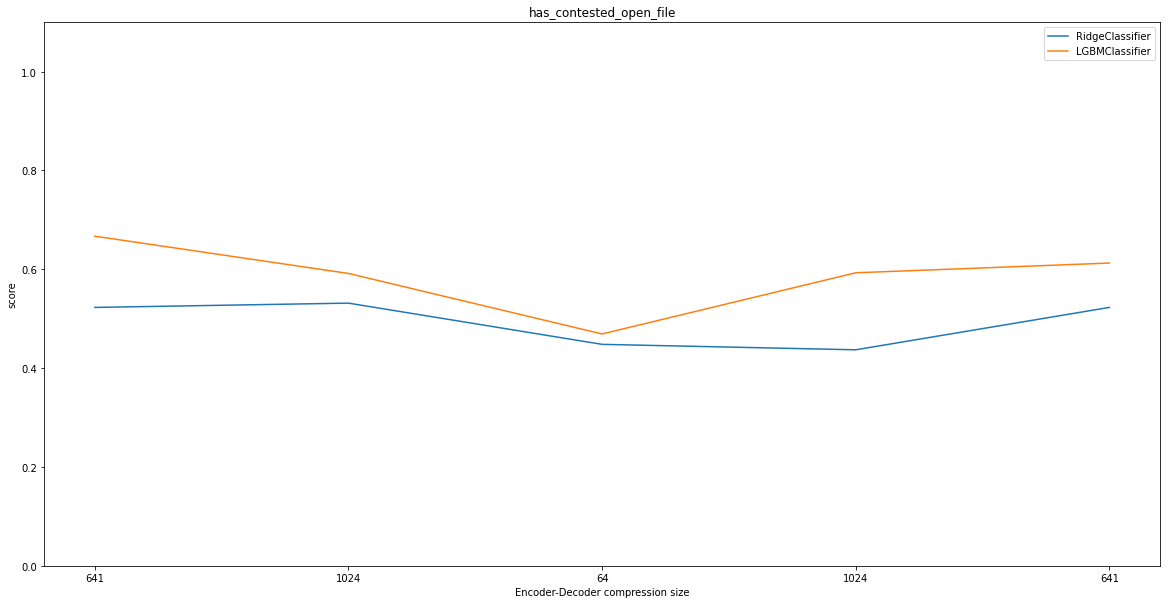

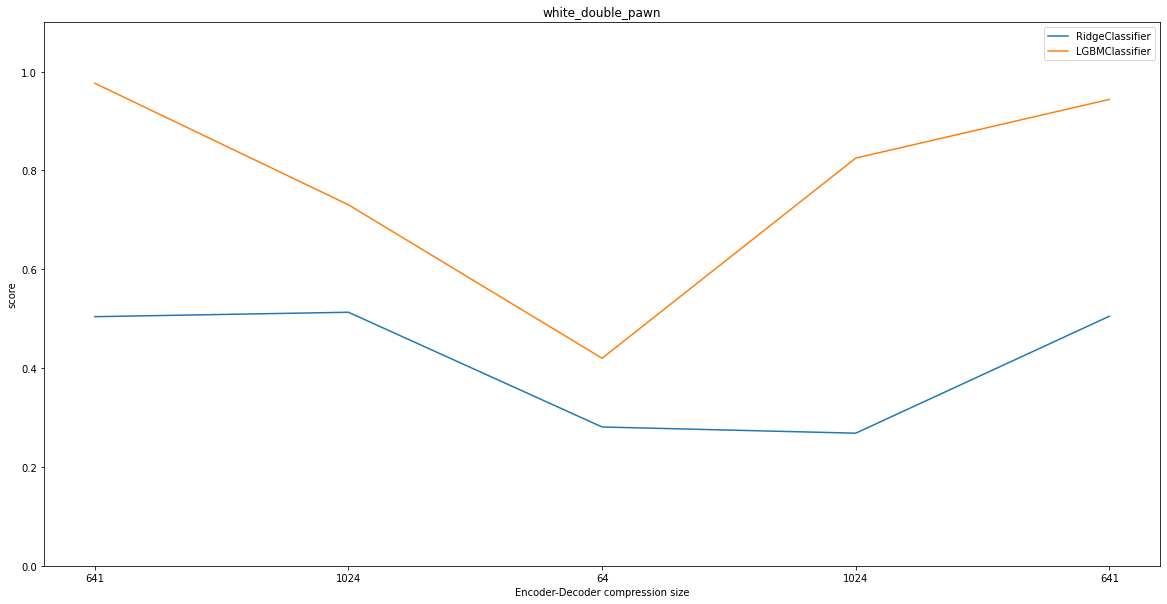

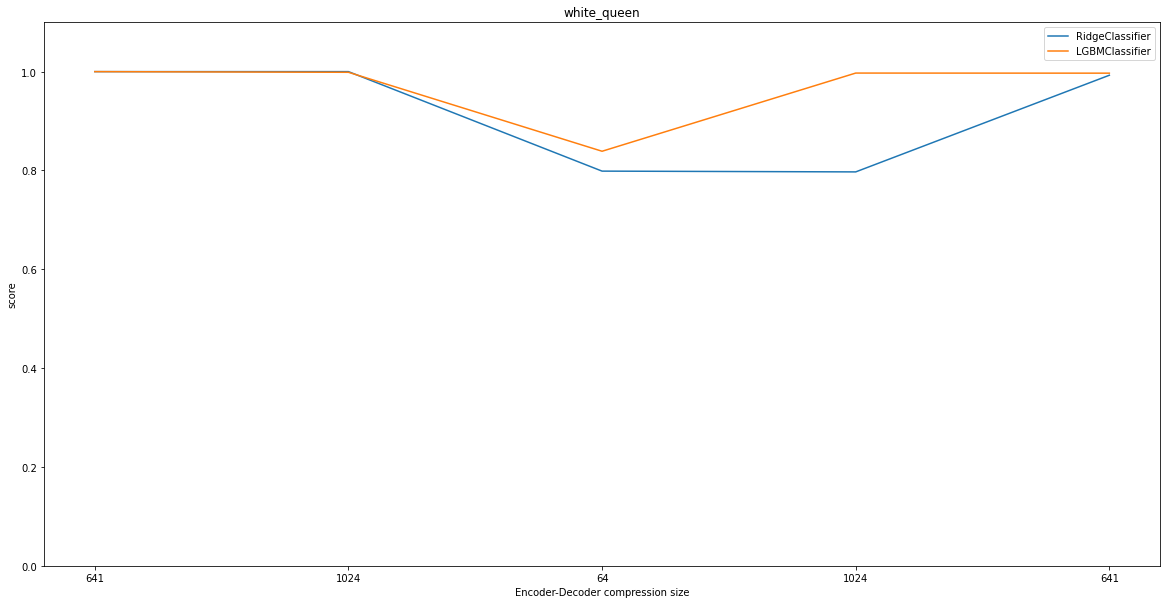

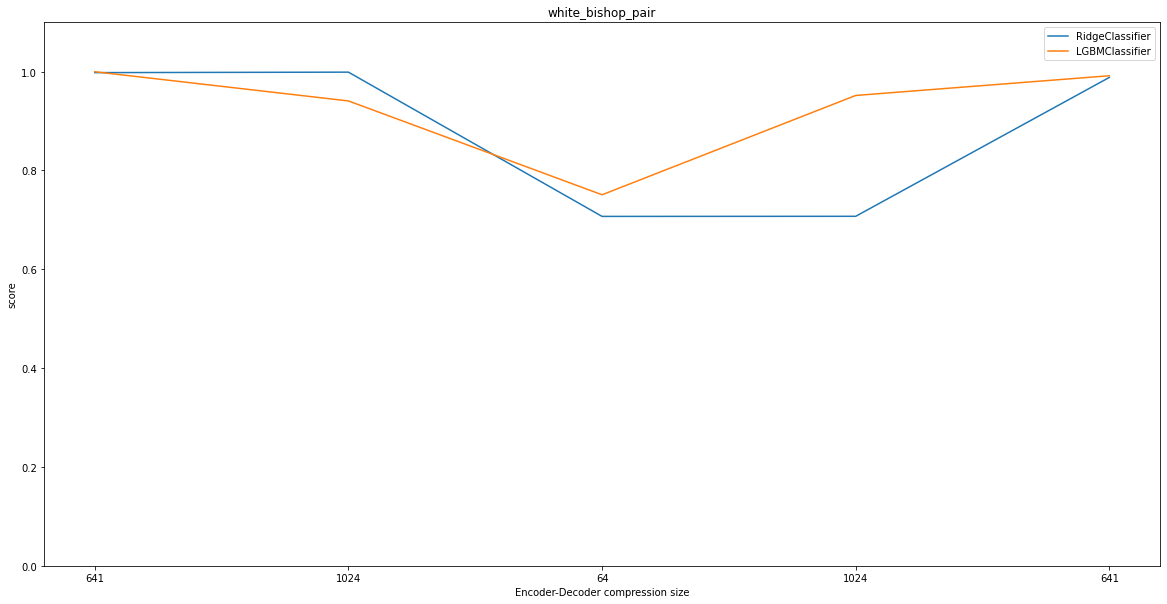

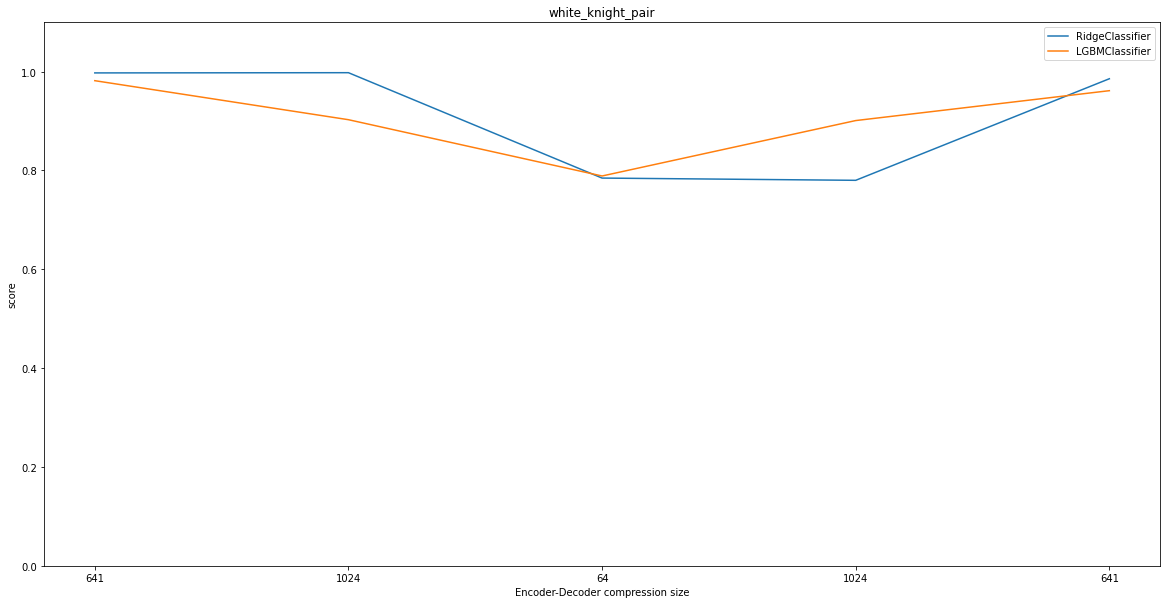

In [ ]:
df_results = pd.read_pickle('data/df_results_small.pkl')
plot_results(df_results)


# Medium Model

In [ ]:
from model_medium import DeepAutoencoder

model = DeepAutoencoder(input_size = 768)
model.load_state_dict(torch.load('models/model_BCE_medium.pt'))



activation = {}
def get_output_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_input_activation(name):
    def hook(model, input, output):
        activation['input_'+name] = input[0].detach()
    return hook

model.encoder_0.register_forward_hook(get_input_activation('encoder_0'))
model.encoder_0.register_forward_hook(get_output_activation('encoder_0'))
model.encoder_1.register_forward_hook(get_output_activation('encoder_1'))
model.encoder_2.register_forward_hook(get_output_activation('encoder_2'))
#model.encoder_3.register_forward_hook(get_output_activation('encoder_3'))
#model.decoder_0.register_forward_hook(get_output_activation('decoder_0'))
model.decoder_1.register_forward_hook(get_output_activation('decoder_1'))
model.decoder_2.register_forward_hook(get_output_activation('decoder_2'))
model.decoder_3.register_forward_hook(get_output_activation('decoder_3'))

model.cuda()

df_activations = get_activations(model, df)
df_activations.head()



150000it [01:41, 1472.11it/s]


,index,input_encoder_0,encoder_0,encoder_1,encoder_2,decoder_1,decoder_2,decoder_3
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.484, -4.598, -7.004, -4.35, -4.445, 2.117,...","[10.55, -4.13, 3.521, -2.795, 2.572, -4.03, -3...","[-0.712, -5.926, 1.009, -0.4004, 0.412, -8.664...","[5.836, 7.65, 2.709, 5.01, -0.518, 3.453, 2.55...","[-5.734, -12.77, -1.745, -9.305, 10.805, -12.7...","[1.9097603e-20, 3.790182e-20, 1.3298859e-19, 2..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.56, -2.328, -6.984, -6.504, -2.201, -3.895...","[17.69, -3.264, 16.08, -2.426, 17.45, -3.277, ...","[-3.693, -3.238, 1.081, -4.547, 4.27, 6.17, 4....","[3.768, 3.574, 1.216, 3.85, 3.252, 10.13, 0.80...","[-5.81, -20.4, 6.895, -8.3, 1.584, -13.164, -1...","[1.0745046e-18, 2.3954789e-18, 9.008285e-19, 3..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.37, 1.108, -3.729, -5.324, -1.504, -6.94, ...","[2.73, -3.521, 15.17, -2.92, 2.94, -3.643, -3....","[-1.679, -7.613, 0.822, -0.2129, 1.506, 0.517,...","[1.516, 4.777, 2.164, 5.89, 0.848, 2.21, 3.158...","[-5.55, -8.555, 6.61, -7.27, 1.092, -8.37, -7....","[8.783386e-17, 2.7091694e-17, 2.0987291e-17, 3..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.639, -2.889, -4.574, -3.32, -1.319, -3.566...","[7.215, -3.51, 4.78, -2.97, 8.414, -4.543, -3....","[11.82, -0.92, 3.732, -5.93, -3.352, -2.871, -...","[4.855, 5.87, 3.506, 1.366, 4.344, 6.11, 9.35,...","[-5.703, -10.04, -9.76, -7.836, 7.83, -12.77, ...","[2.7332433e-12, 4.8487533e-12, 1.3272914e-11, ..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.74, -4.04, -4.098, -2.795, -2.244, -3.482,...","[6.957, -2.639, 12.29, -3.639, 9.8, -3.633, -3...","[1.747, -0.312, -2.705, 2.227, 0.972, 1.256, 0...","[4.36, 5.18, 2.08, 4.723, 3.047, 6.11, 4.004, ...","[-5.34, -14.695, -10.85, -6.707, 5.367, -10.87...","[2.0589511e-11, 1.511896e-11, 2.5583577e-11, 1..."


In [ ]:

test_size = 0.33
metric = classification_cost

verbose = False

undersample = RandomUnderSampler(
    sampling_strategy="majority"
)

concept_models = [
    RidgeClassifier(), 
    LGBMClassifier()
    ]

input_names = [
    'input_encoder_0', 
    'encoder_0', 
    'encoder_1', 
    'encoder_2', 
    #'encoder_3', 
    #'decoder_0', 
    'decoder_1', 
    'decoder_2',
    'decoder_3'
    ]

df_results = train_concept_models(concept_models, input_names, target_names, df_activations, df, undersample, test_size, metric, verbose = verbose)

df_results.to_pickle('data/df_results_medium.pkl')

X: input_encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: input_encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: input_encoder_0, y: white_queen, model_name: .RidgeClassifier
X: input_encoder_0, y: white_bishop_pair, model_name: .RidgeClassifier
X: input_encoder_0, y: white_knight_pair, model_name: .RidgeClassifier
X: encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_0, y: white_bishop_pair, model_name: .RidgeClassifier
X: encoder_0, y: white_knight_pair, model_name: .RidgeClassifier
X: encoder_1, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_1, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_1, y: white_queen, model_name: .RidgeClassifier
X: encoder_1, y: white_bishop_pair, model_name: .RidgeClassifier
X: encoder_1, y: white_knight_pair, model_name: .RidgeClassi

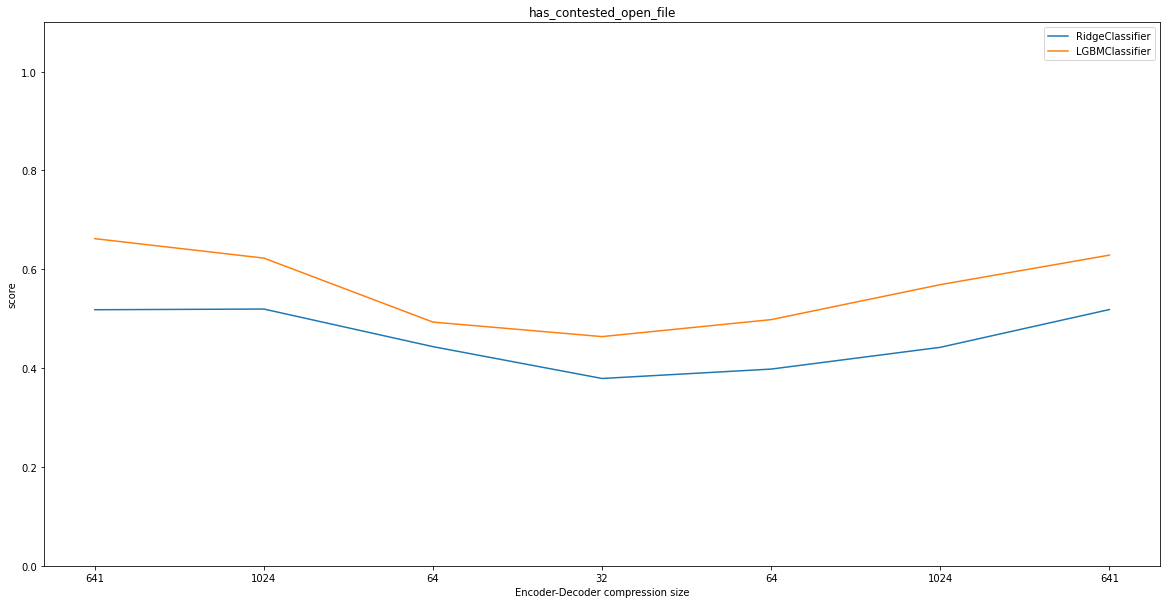

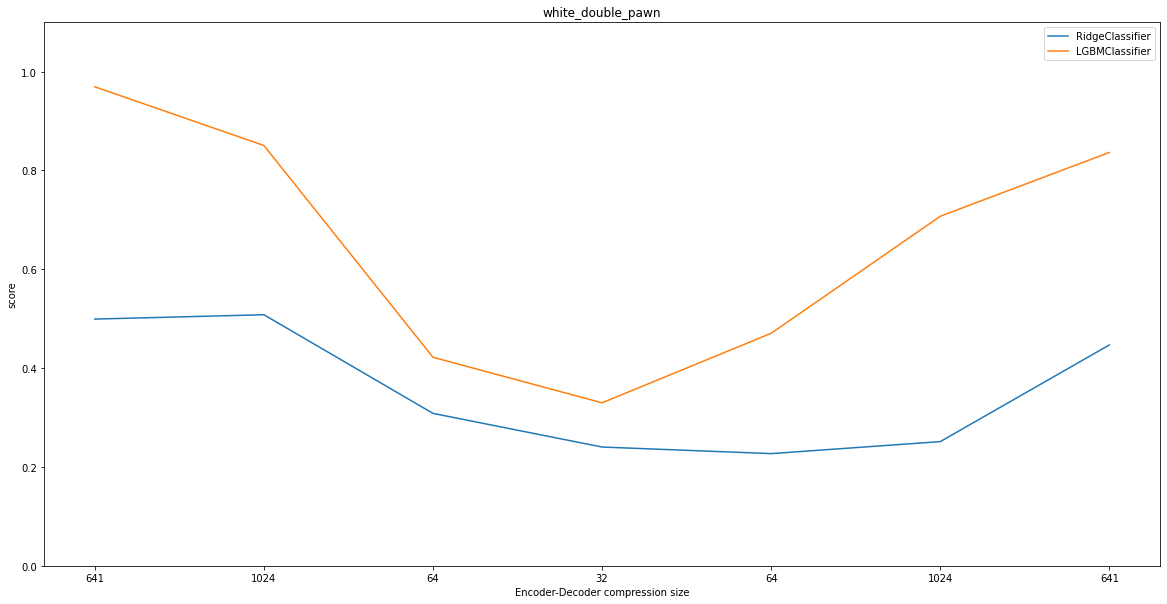

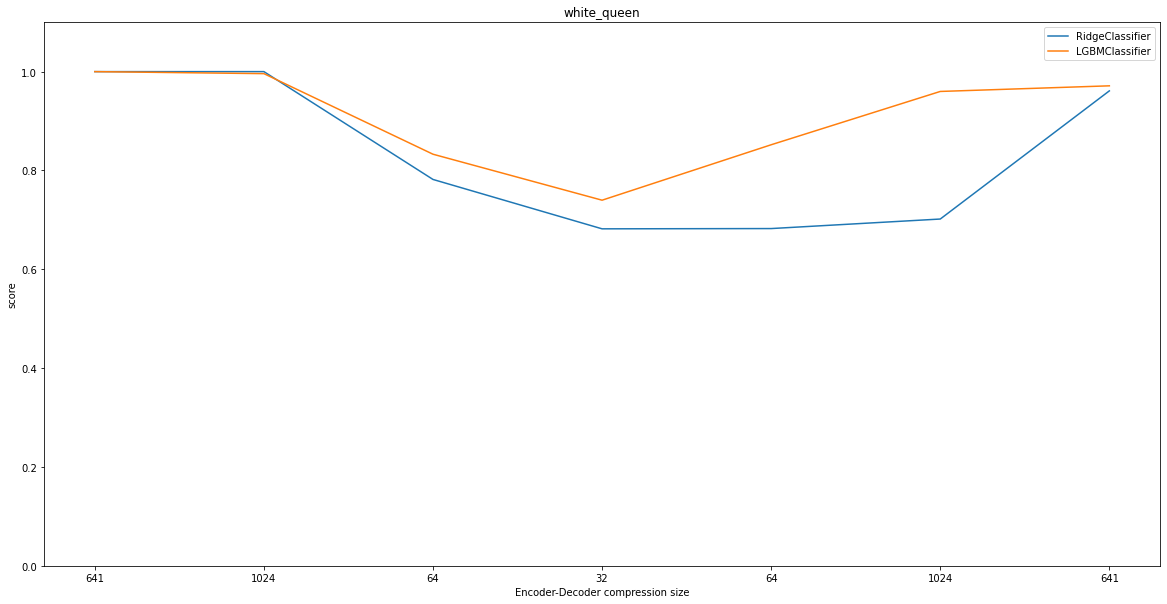

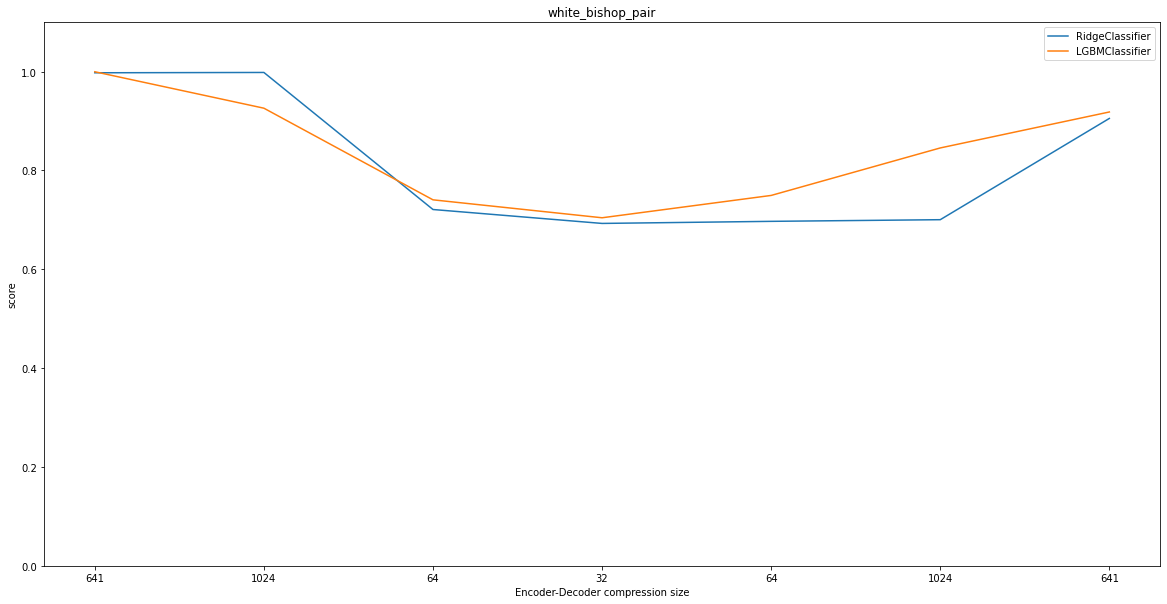

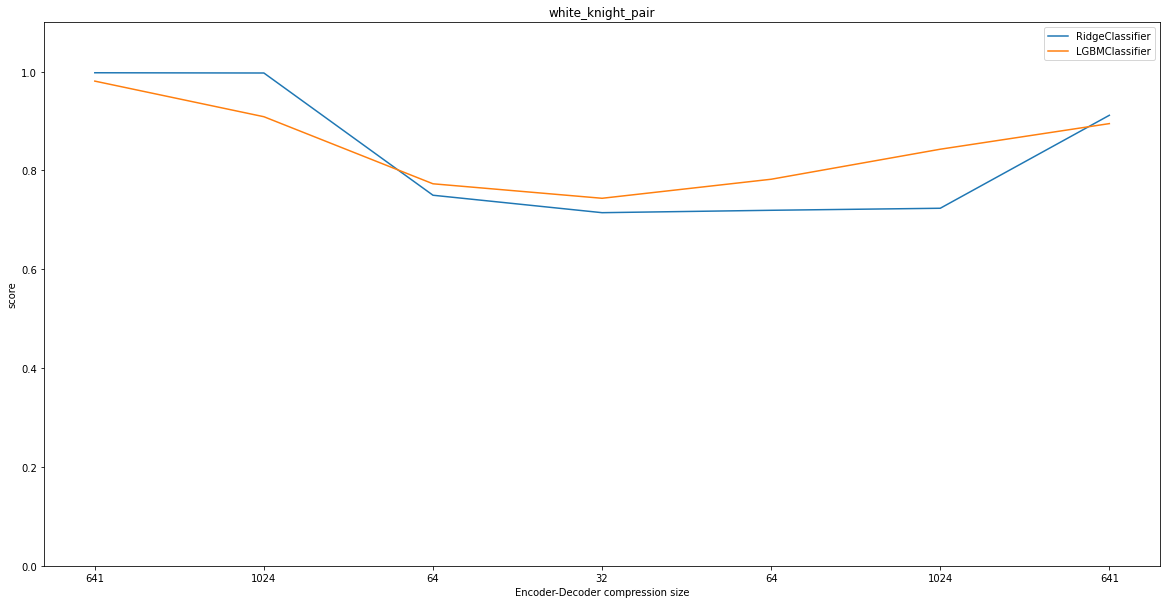

In [ ]:
df_results = pd.read_pickle('data/df_results_medium.pkl')
plot_results(df_results)


# Large Model

In [ ]:
from model import DeepAutoencoder

model = DeepAutoencoder(input_size = 768)
model.load_state_dict(torch.load('models/model_BCE.pt'))



activation = {}
def get_output_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_input_activation(name):
    def hook(model, input, output):
        activation['input_'+name] = input[0].detach()
    return hook

model.encoder_0.register_forward_hook(get_input_activation('encoder_0'))
model.encoder_0.register_forward_hook(get_output_activation('encoder_0'))
model.encoder_1.register_forward_hook(get_output_activation('encoder_1'))
model.encoder_2.register_forward_hook(get_output_activation('encoder_2'))
model.encoder_3.register_forward_hook(get_output_activation('encoder_3'))
model.decoder_0.register_forward_hook(get_output_activation('decoder_0'))
model.decoder_1.register_forward_hook(get_output_activation('decoder_1'))
model.decoder_2.register_forward_hook(get_output_activation('decoder_2'))
model.decoder_3.register_forward_hook(get_output_activation('decoder_3'))

model.cuda()

df_activations = get_activations(model, df)
df_activations.head()




150000it [01:53, 1316.25it/s]


,index,input_encoder_0,encoder_0,encoder_1,encoder_2,encoder_3,decoder_0,decoder_1,decoder_2,decoder_3
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-10.75, -5.89, -3.496, -7.027, -5.793, -5.945...","[-3.326, -3.625, -1.477, -4.094, 27.34, 7.86, ...","[-19.6, 19.83, -12.375, 16.84, 6.12, 17.8, -17...","[-3.652, -2.47, 4.754, -8.86, -0.0915, -11.04,...","[3.047, -5.906, 3.951, 2.621, 4.074, 4.484, 3....","[-3.877, -3.902, -9.64, -5.312, -3.014, -5.902...","[-8.43, -26.22, -17.39, -13.15, -2.92, -25.44,...","[4.7506175e-20, 1.2237424e-19, 2.1331274e-19, ..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.83, -4.05, -3.123, -11.57, -5.688, -7.645,...","[-4.113, -2.762, -1.438, -4.24, 14.5, 9.14, 22...","[-16.62, 22.03, -9.61, 17.8, 13.15, 5.7, -14.8...","[-5.43, 3.932, 0.3994, -19.92, 0.913, -1.869, ...","[7.086, -6.074, 3.496, 2.67, 4.895, 4.64, 1.84...","[-5.457, -4.402, -12.35, 1.206, -3.576, -2.326...","[1.402, -25.78, -25.27, -2.496, -19.36, -16.58...","[3.3527493e-17, 8.76996e-17, 7.137574e-17, 6.2..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.99, -3.797, -3.824, -7.145, -4.97, -4.04, ...","[-4.4, -3.857, -1.587, -4.773, 4.066, 5.984, 5...","[-12.984, 11.24, -11.02, 14.45, 9.59, 7.676, -...","[2.41, -1.809, 1.782, -11.27, 4.992, 7.676, 0....","[5.004, -4.82, 3.72, -1.473, 5.832, 5.883, 1.7...","[-3.182, -2.137, -7.5, 1.63, -2.67, -4.992, 3....","[-1.662, -16.88, -22.33, -1.122, -13.5, -13.81...","[1.1000908e-18, 3.0510811e-18, 1.1624466e-17, ..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-7.832, -4.598, -2.68, 0.2013, -4.49, -3.45, ...","[-3.484, -3.453, -1.44, -4.836, 15.266, 4.203,...","[-15.23, 10.36, -10.13, 4.926, 7.15, 4.445, -1...","[-1.794, 4.883, 4.43, -3.746, -0.862, 2.41, 2....","[4.223, -4.82, 2.97, -0.5864, 1.155, 3.713, 2....","[-2.447, -3.139, -5.48, -2.105, -1.465, 2.492,...","[-0.2339, -18.05, -10.48, -8.945, -18.19, -17....","[1.1026937e-14, 1.2416233e-14, 1.8495054e-14, ..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.523, -3.504, -2.146, 0.469, -3.889, -3.178...","[-3.568, -3.406, -1.671, -4.566, 14.77, 1.256,...","[-12.766, 12.95, -6.562, 9.12, 6.25, 5.207, -1...","[0.64, -0.9653, 0.4604, -7.54, 0.2793, 0.876, ...","[3.55, -5.723, 1.982, -0.357, 2.512, 2.146, 2....","[-2.795, -3.027, -4.742, 0.6875, -2.924, 1.585...","[0.02321, -21.86, -14.92, -4.04, -17.05, -10.9...","[4.5833276e-10, 8.573603e-10, 5.811356e-10, 3...."


In [ ]:

test_size = 0.33
metric = classification_cost

verbose = False

undersample = RandomUnderSampler(
    sampling_strategy="majority"
)

concept_models = [
    RidgeClassifier(), 
    LGBMClassifier()
    ]

input_names = [
    'input_encoder_0', 
    'encoder_0', 
    'encoder_1', 
    'encoder_2', 
    'encoder_3', 
    'decoder_0', 
    'decoder_1', 
    'decoder_2',
    'decoder_3'
    ]

df_results = train_concept_models(concept_models, input_names, target_names, df_activations, df, undersample, test_size, metric, verbose = verbose)


df_results.to_pickle('data/df_results_large.pkl')

X: input_encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: input_encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: input_encoder_0, y: white_queen, model_name: .RidgeClassifier
X: input_encoder_0, y: white_bishop_pair, model_name: .RidgeClassifier
X: input_encoder_0, y: white_knight_pair, model_name: .RidgeClassifier
X: encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_0, y: white_bishop_pair, model_name: .RidgeClassifier
X: encoder_0, y: white_knight_pair, model_name: .RidgeClassifier
X: encoder_1, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_1, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_1, y: white_queen, model_name: .RidgeClassifier
X: encoder_1, y: white_bishop_pair, model_name: .RidgeClassifier
X: encoder_1, y: white_knight_pair, model_name: .RidgeClassi

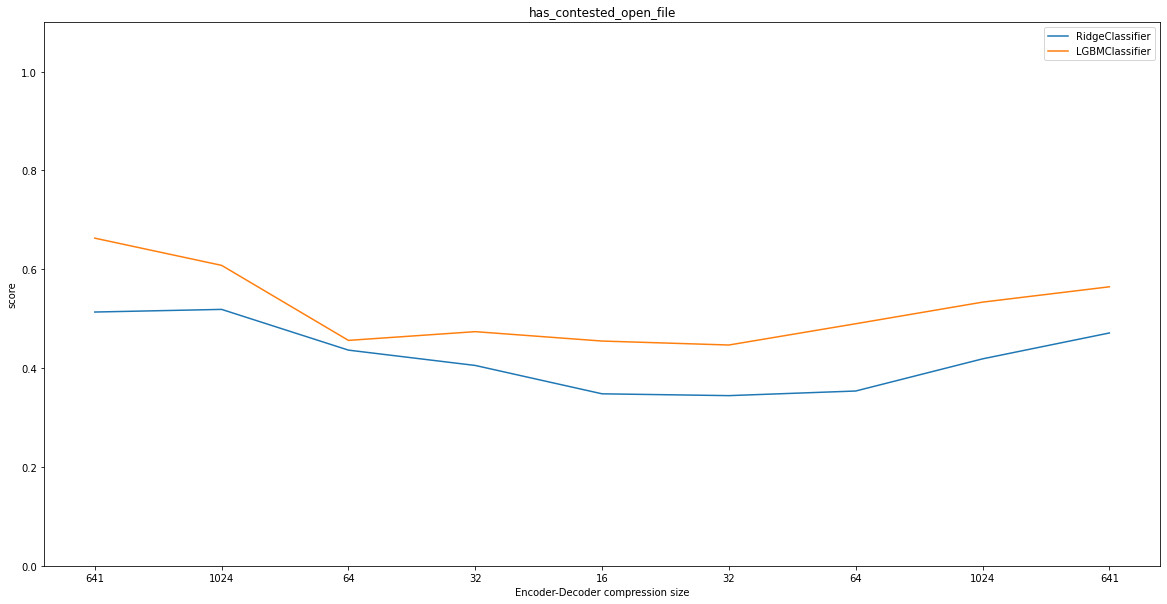

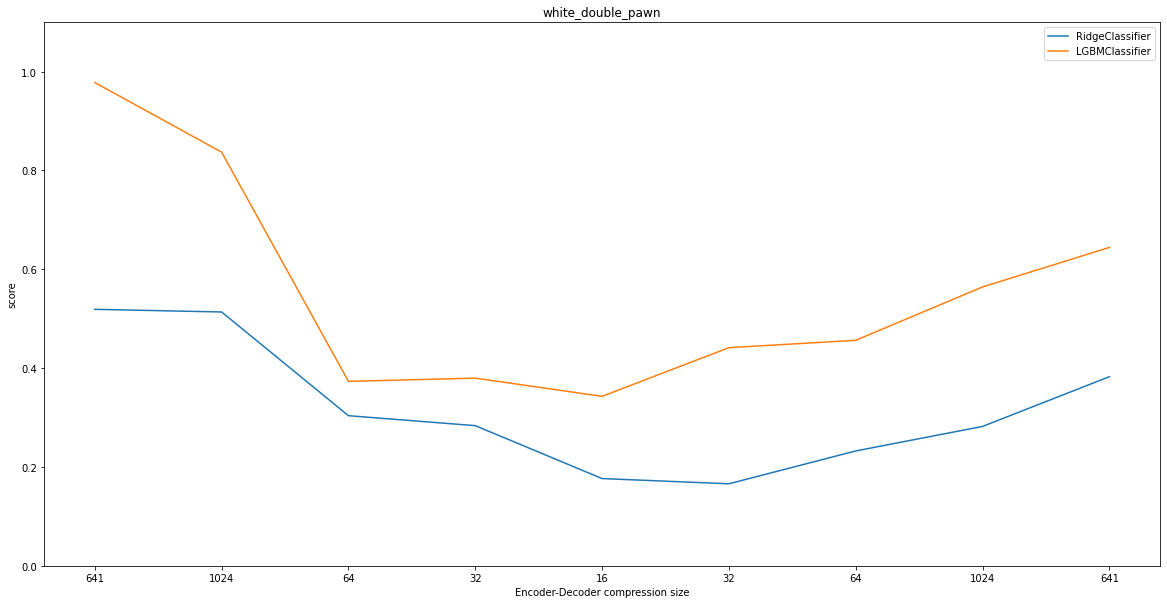

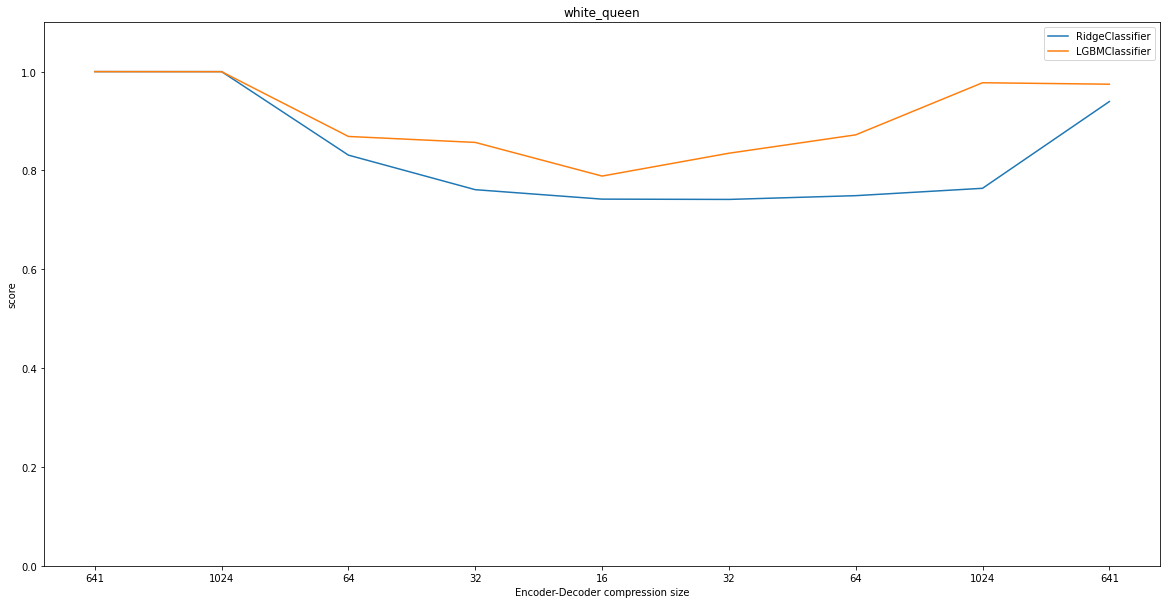

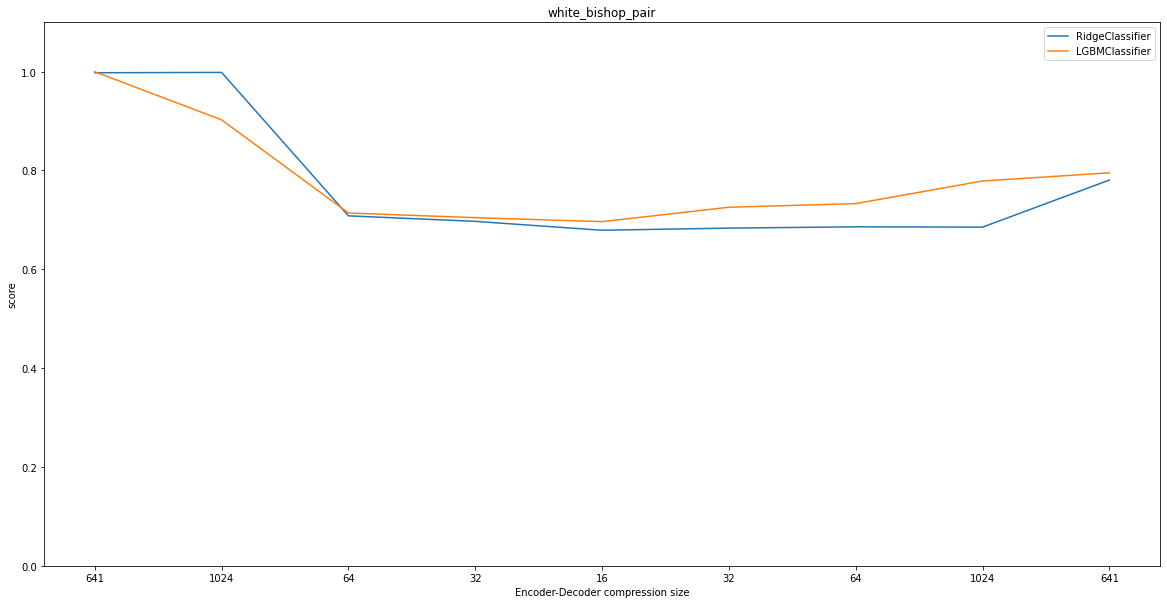

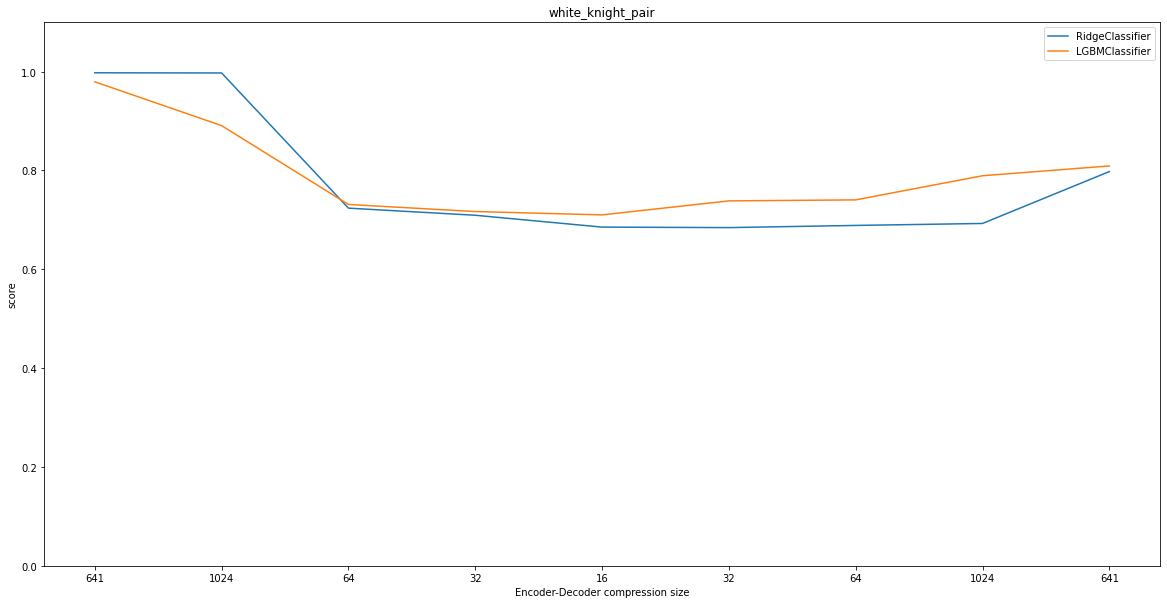

In [ ]:
df_results = pd.read_pickle('data/df_results_large.pkl')
plot_results(df_results)